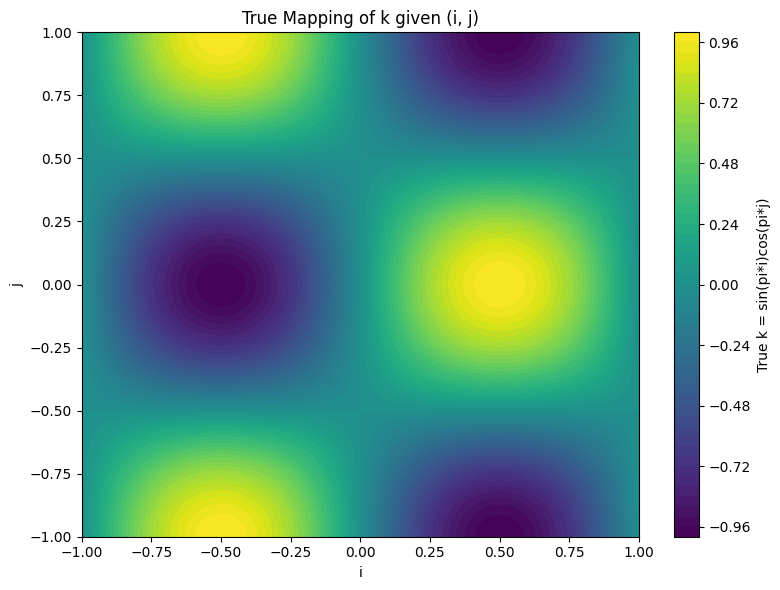

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid
i_grid = np.linspace(-1, 1, 200)
j_grid = np.linspace(-1, 1, 200)
ii, jj = np.meshgrid(i_grid, j_grid)

# True function
kk = np.sin(np.pi * ii) * np.cos(np.pi * jj)

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(ii, jj, kk, levels=50, cmap='viridis')
plt.colorbar(contour, label='True k = sin(pi*i)cos(pi*j)')
plt.xlabel('i')
plt.ylabel('j')
plt.title('True Mapping of k given (i, j)')
plt.tight_layout()
plt.savefig("example_contour.png")
plt.show()

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the FlexibleConditional model
class FlexibleConditional(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FlexibleConditional, self).__init__()
        
        # Linear component
        self.linear = nn.Linear(input_dim, output_dim)
        
        # Nonlinear component (small MLP)
        self.nonlinear = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        # Learnable mixing coefficient
        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, i, j):
        # Concatenate inputs (i, j)
        x = torch.cat([i, j], dim=-1)
        
        linear_out = self.linear(x)
        nonlinear_out = self.nonlinear(x)
        
        # Mix the two outputs
        alpha = torch.sigmoid(self.alpha)  # Force between (0,1)
        output = alpha * linear_out + (1 - alpha) * nonlinear_out
        return output

# Generate synthetic data
def generate_synthetic_data(n_samples=5000):
    i = torch.rand(n_samples, 1) * 2 - 1
    j = torch.rand(n_samples, 1) * 2 - 1
    k = torch.sin(torch.pi * i) * torch.cos(torch.pi * j)
    return i, j, k

# Train the model
def train_model():
    input_dim = 2
    hidden_dim = 64
    output_dim = 1
    model = FlexibleConditional(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    i, j, k = generate_synthetic_data()
    dataset = torch.utils.data.TensorDataset(i, j, k)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

    for epoch in range(200):  # 200 epochs!
        for batch in dataloader:
            bi, bj, bk = batch
            pred_k = model(bi, bj)
            loss = nn.functional.mse_loss(pred_k, bk)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

# Generate and save contour plot
def save_contour_plot(model, filename="example_contour.png"):
    i_grid = np.linspace(-1, 1, 100)
    j_grid = np.linspace(-1, 1, 100)
    ii, jj = np.meshgrid(i_grid, j_grid)
    inputs_i = torch.tensor(ii.flatten(), dtype=torch.float32).unsqueeze(1)
    inputs_j = torch.tensor(jj.flatten(), dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        pred_k = model(inputs_i, inputs_j).numpy().reshape(ii.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(ii, jj, pred_k, levels=50, cmap='viridis')
    plt.colorbar(label='Predicted k')
    plt.xlabel('i')
    plt.ylabel('j')
    plt.title('Learned Flexible Mapping of k given (i, j)')
    plt.savefig(filename)
    plt.close()

# Main execution
model = train_model()
save_contour_plot(model)



In [7]:
# Example dimensions
dim_i = 1
dim_j = 1
dim_k = 1

input_dim = dim_i + dim_j  # because we concat (i, j)
hidden_dim = 64
output_dim = dim_k

model = FlexibleConditional(input_dim, hidden_dim, output_dim)


In [8]:
# Random synthetic data (replace this later with real datasets!)
i = torch.randn(1000, 1)  # (1000 examples, 1 feature)
j = torch.randn(1000, 1)
k_true = torch.sin(torch.pi * i) * torch.cos(torch.pi * j)  # True relationship


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    optimizer.zero_grad()
    pred_k = model(i, j)
    loss = nn.functional.mse_loss(pred_k, k_true)  # Mean Squared Error
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.504451
Epoch 10: Loss = 0.450199
Epoch 20: Loss = 0.403583
Epoch 30: Loss = 0.364220
Epoch 40: Loss = 0.331755


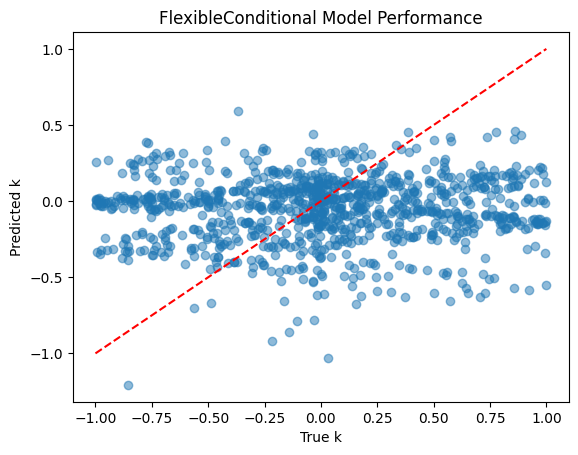

In [10]:
import matplotlib.pyplot as plt
with torch.no_grad():
    pred_k = model(i, j)

plt.scatter(k_true.numpy(), pred_k.numpy(), alpha=0.5)
plt.xlabel("True k")
plt.ylabel("Predicted k")
plt.title("FlexibleConditional Model Performance")
plt.plot([-1,1], [-1,1], color='red', linestyle='--')  # Ideal line
plt.show()
